In [1]:
import os
import numpy as np
import pandas as pd
import glob
import math

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#image imports
import imageio

import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# utils
from IPython.display import clear_output

### Labels used in the process
* Out of 19 only 12 labes or interest are used and defined here

In [2]:
label_to_name = {
    0: "Nucleoplasm",
    1: "Nucleoli",
    2: "Nucleoli fibrillar center",
    3: "Nuclear speckles",
    4: "Nuclear bodies",
    5: "Endoplasmic reticulum",
    6: "Golgi apparatus",
    7: "Intermediate filaments",
    8: "Centrosome",
    9: "Plasma membrane",
    10: "Mitochondria",
    11: "Cytosol"
}

name_label = {
    "Nucleoplasm":0,
    "Nucleoli":1,
    "Nucleoli fibrillar center":2,
    "Nuclear speckles":3,
    "Nuclear bodies":4,
    "Endoplasmic reticulum":5,
    "Golgi apparatus":6,
    "Intermediate filaments":7,
    "Centrosome":8,
    "Plasma membrane":9,
    "Mitochondria":10,
    "Cytosol":11
}

### Constants used for modeling
* Each folder has files for all the 12 classes outlined abouve.
* image size choosen as 512 X 512

In [3]:
IMAGE_SIZE = [512,512]

train_path = 'data/flow/train'
validation_path = 'data/flow/validation'
test_path = 'data/flow/test'
batch_size = 24
label_count = 12

In [4]:
## TBD -- outline how many samples in each class label..

### Geenrators for the train, validation and test
* To train models, keras image generator and images from `labels` directories are used
* Image files are created in the folders such a way that keras `ImageDataGenerator` and `flow_from_directory` utils can be used to read and feed them to neural network

In [5]:
# image generator for train and validation.
# For trainin and test image manipulation parameters are defined as below
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.3,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

# Test generator, feed the images as is
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [6]:
# create generators
train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
    seed=123
)
valid_generator = gen.flow_from_directory(
    validation_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
    seed=456
)

test_gen = test_gen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=batch_size
)

Found 113780 images belonging to 12 classes.
Found 28445 images belonging to 12 classes.
Found 9482 images belonging to 12 classes.


## Define model

In [7]:
resnet_101 = ResNet101(
    input_shape=[512, 512, 3], 
    include_top=False, 
    weights="imagenet")
x = Flatten()(resnet_101.output)
x = Dense(label_count, activation='softmax')(x)
resnet_101_model = Model(resnet_101.input, x)

## Model summary

In [8]:
resnet_101_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [9]:
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.0005,amsgrad=True)
resnet_101_model.compile(loss='categorical_crossentropy', optimizer=opt_adam, metrics=['accuracy'])

## Load saved model

In [10]:
# resnet_101_model = tf.keras.models.load_model('saved-model/resnet_101_model/', compile=False)

In [11]:
# opt = tf.keras.optimizers.Adam(learning_rate=0.0000001, amsgrad=True)
# opt = tf.keras.optimizers.Nadam(learning_rate=0.000001,beta_1=0.9, beta_2=0.999)
# resnet_101_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Train and validate model

In [12]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
initial_learning_rate = 0.0005
def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 25.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

lr = LearningRateScheduler(lr_step_decay, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1,restore_best_weights=True)
cp = ModelCheckpoint(filepath='saved-model/resnet_101_model', save_weights_only=False,monitor='val_accuracy', mode='max',save_best_only=True)

In [13]:
result = resnet_101_model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=200,
    steps_per_epoch=120,
    validation_steps=30,
    callbacks=[lr,es,cp]
)

C:\Users\sriha\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0005.
120/120 [==============================] - 159s 975ms/step - loss: 9.3137 - accuracy: 0.1528 - val_loss: 13.9319 - val_accuracy: 0.1931
INFO:tensorflow:Assets written to: saved-model\resnet_101_model\assets
Epoch 2/200

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0005.
120/120 [==============================] - 115s 952ms/step - loss: 2.4790 - accuracy: 0.1891 - val_loss: 4.1725 - val_accuracy: 0.1917
Epoch 3/200

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005.
120/120 [==============================] - 116s 961ms/step - loss: 2.4153 - accuracy: 0.1924 - val_loss: 2.4566 - val_accuracy: 0.2139
INFO:tensorflow:Assets written to: saved-model\resnet_101_model\assets
Epoch 4/200

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0005.
120/120 [==============================] - 116s 967ms/step - loss: 2.2910 - accuracy: 0.2409 - val_loss: 2.4834 - val_accura

## Loss and accuracy visualizations

In [14]:
result

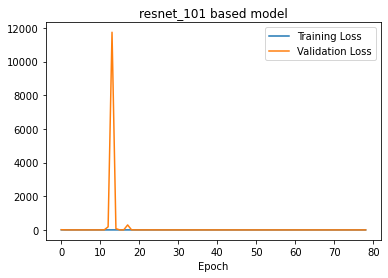

In [15]:
plt.plot(result.history['loss'], label='Training Loss',)
plt.plot(result.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.title('resnet_101 based model')
plt.legend()

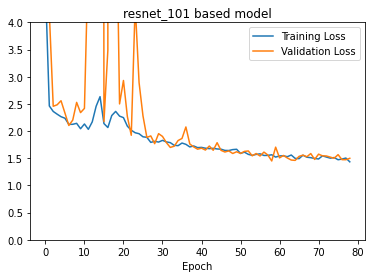

In [27]:
plt.plot(result.history['loss'], label='Training Loss',)
plt.plot(result.history['val_loss'], label='Validation Loss')
plt.ylim(0,4)
plt.xlabel('Epoch')
plt.title('resnet_101 based model')
plt.legend()

### Accuracy

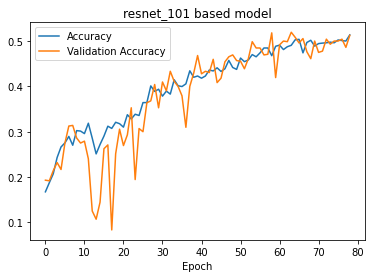

In [16]:
plt.plot(result.history['accuracy'], label='Accuracy')
plt.plot(result.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.title('resnet_101 based model')
plt.legend()

## Test set validation

In [17]:
labels_from_generator = (test_gen.class_indices)
labels_from_generator = [k for k,v in labels_from_generator.items()]
test_gen.reset()
labels_from_generator

['Centrosome',
 'Cytosol',
 'Endoplasmic reticulum',
 'Golgi apparatus',
 'Intermediate filaments',
 'Mitochondria',
 'Nuclear bodies',
 'Nuclear speckles',
 'Nucleoli',
 'Nucleoli fibrillar center',
 'Nucleoplasm',
 'Plasma membrane']

In [18]:
def get_confusion_matrix(model, N):
    # we need to see the data in the same order
    # for both predictions and targets
    print("Generating confusion matrix. Total images to predict", N)
    predictions = []
    targets = []
    i = 0
    for x, y in test_gen:
        i += 1
        if i % 100 == 0:
            print(f'Finished predicting {i} batches')
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break

    cm = confusion_matrix(targets, predictions)
    return cm

In [19]:
%%time
test_gen.reset()
result_cm = get_confusion_matrix( resnet_101_model,9482)

Generating confusion matrix. Total images to predict 9482
Finished predicting 100 batches
Finished predicting 200 batches
Finished predicting 300 batches
Wall time: 2min 2s


In [20]:
# print confusion matrix numbers
print(result_cm)

[[ 114   62    4   31    2   56   53    3   21    8  133   83]
 [  25  552   43   12    6   95   10    1    4    1  119  181]
 [   7  176  131    2   23   77    1    1    2    0   46   34]
 [  22   41    6  270   10  185    9   22   24    5  102   42]
 [   8   51   47    6  185   74    4    3    7    0   33   51]
 [  13  138   59   31   35  769    1   12    2    1   90   46]
 [  54   48    0   22    1   36  129   23   15   27  218   26]
 [   5    9    5   15    4   36    2  430   11    0  233    5]
 [  22   25    0   24    3   22    5   13  263   15   70   16]
 [  21   46    1   81    2   32   47   16   49   96   49   16]
 [  28  137    1   17    1   66   12   35    6    1 1347   21]
 [  35  268   16   17   11   79    8    1    2    0   54  508]]


In [21]:
# Normalise to show percentages
cmn = result_cm.astype('float') / result_cm.sum(axis=1)[:, np.newaxis]

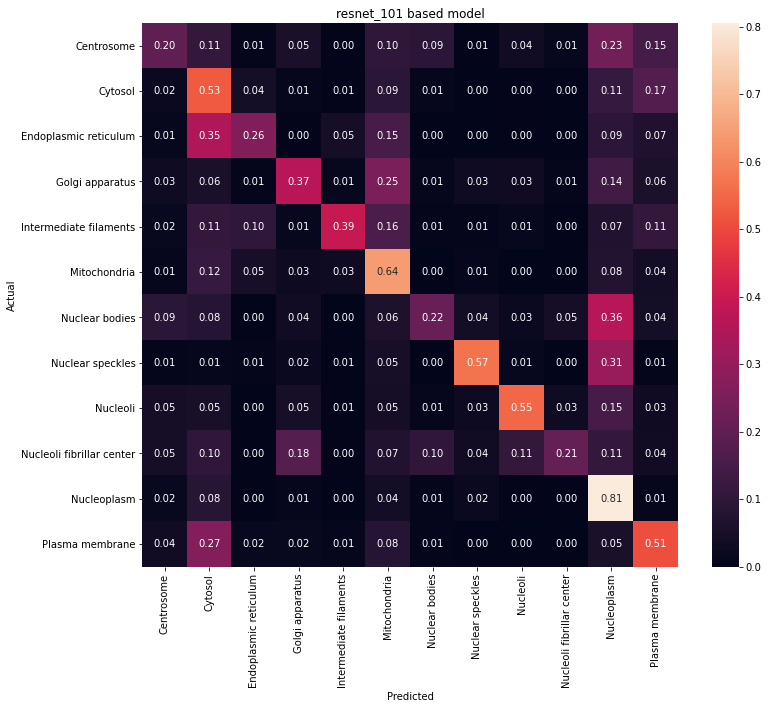

In [22]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels_from_generator, yticklabels=labels_from_generator)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('resnet_101 based model')
plt.show(block=False)